In [1]:
%load_ext lab_black
%load_ext autotime
import numpy as np
import pandas as pd

time: 368 ms (started: 2023-06-11 15:58:58 -07:00)


[Galaxy10 SDSS](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html) contains nearly 22,000 69x69 color images of galaxies from the [Sloan Digital Sky Survey](http://www.sdss.org/). They were classified into 10 groups via crowd-sourcing on [Galaxy Zoo](https://www.galaxyzoo.org/). This dataset was originally called just "Galaxy 10" but has been superceded by the [Galaxy10 DECals](https://astronn.readthedocs.io/en/latest/galaxy10.html) dataset.

## Read the file

When I tried to access this file, I got an SSL certificate error. As a result, the call to `requests.get` below uses the `verify=False`. This is the source of the warnings below.

In [2]:
from io import BytesIO

import h5py
import numpy as np
import requests

url = "http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5"
req = requests.get(url, allow_redirects=True, verify=False, timeout=10)

with h5py.File(BytesIO(req.content), "r") as file:
    images = np.array(file["images"])
    labels = np.array(file["ans"])

/home/james/dev/drnb/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'astro.utoronto.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/james/dev/drnb/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.astro.utoronto.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


time: 11.9 s (started: 2023-06-11 15:59:01 -07:00)


In [3]:
images.shape

(21785, 69, 69, 3)

time: 7.06 ms (started: 2023-06-11 15:59:16 -07:00)


In [4]:
labels

array([2, 2, 4, ..., 2, 9, 2], dtype=uint8)

time: 4.44 ms (started: 2023-06-11 15:59:16 -07:00)


The 10 classes are imbalanced:

In [5]:
import collections

sorted(collections.Counter(labels).items())

[(0, 3461),
 (1, 6997),
 (2, 6292),
 (3, 349),
 (4, 1534),
 (5, 17),
 (6, 589),
 (7, 1121),
 (8, 906),
 (9, 519)]

time: 7.5 ms (started: 2023-06-11 15:59:18 -07:00)


As you can see, there are only 17 examples of class 5 (which is the "Disk, Edge-on, Boxy Bulge" class).

## View a galaxy image

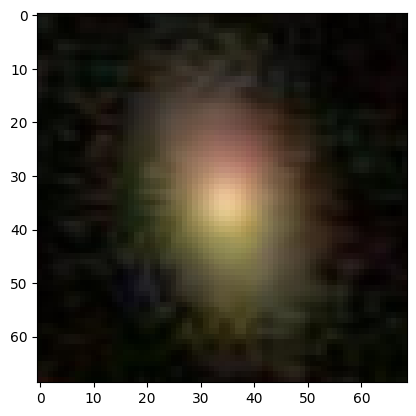

time: 549 ms (started: 2023-06-11 15:59:21 -07:00)


In [6]:
import matplotlib.pyplot as plt

plt.imshow(
    images[0],
    interpolation="nearest",
    vmin=0,
    vmax=255,
)

## Pipeline

In [7]:
data = images.reshape(
    (images.shape[0], images.shape[1] * images.shape[2] * images.shape[3])
)

time: 3.01 ms (started: 2023-06-11 15:59:25 -07:00)


In [8]:
data.shape

(21785, 14283)

time: 4.9 ms (started: 2023-06-11 15:59:26 -07:00)


The class names can be found at <https://github.com/henrysky/astroNN/blob/9cd32944285634ba26f83fb414ea766693627004/docs/source/galaxy10sdss.rst>.

In [9]:
class_names = [
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral",
]

time: 1.98 ms (started: 2023-06-11 15:59:28 -07:00)


In [10]:
from drnb.util import categorize, codes_to_categories

target = pd.DataFrame(
    dict(
        Label=labels, Class_Name=codes_to_categories(labels, class_names, "Class_Name")
    )
)
categorize(target, "Label")
target

,Label,Class_Name
0,2,"Smooth, in-between round"
1,2,"Smooth, in-between round"
2,4,"Disk, Edge-on, Rounded Bulge"
3,2,"Smooth, in-between round"
4,4,"Disk, Edge-on, Rounded Bulge"
...,...,...
21780,2,"Smooth, in-between round"
21781,1,"Smooth, Completely round"
21782,2,"Smooth, in-between round"
21783,9,"Disk, Face-on, Loose Spiral"


time: 75.8 ms (started: 2023-06-11 15:59:30 -07:00)


In [12]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "galaxy10sdss",
    data=data,
    target=target,
    tags=["image", "vhighdim"],
    url="https://astronn.readthedocs.io/en/latest/galaxy10sdss.html",
    verbose=True,
)

[16:41:01] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=27860;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=280241;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#493\493]8;;\

           INFO     Initial data shape: (21785, 14283)                                               ]8;id=121880;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=970173;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#75\75]8;;\

           INFO     Keeping all columns                                                            ]8;id=447302;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=376769;file:///home/james/dev/drnb/src/drnb/preprocess.py#67\67]8;;\

           INFO     Data shape after filtering columns: (21785, 14283)                              ]8;id=626001;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=674770;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=610463;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=197252;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#130\130]8;;\

           INFO     Data shape after filtering NAs: (21785, 14283)                                  ]8;id=571168;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=802575;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#141\141]8;;\

[16:41:05] INFO     Checked for duplicates: found 0                                                 ]8;id=143412;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=225372;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#153\153]8;;\

           INFO     No scaling                                                                     ]8;id=586967;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=437;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=47938;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=590625;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     Writing data for galaxy10sdss                                                   ]8;id=13760;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=190220;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#222\222]8;;\

[16:46:10] INFO     Processing target with initial shape (21785, 2)                                 ]8;id=506695;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=884243;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#193\193]8;;\

           INFO     Keeping all columns                                                            ]8;id=556531;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=35409;file:///home/james/dev/drnb/src/drnb/preprocess.py#67\67]8;;\

           INFO     Writing target for galaxy10sdss                                                 ]8;id=815137;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=923554;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#222\222]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=728475;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=11806;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#237\237]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=513358;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=725440;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=564660;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=511558;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=51675;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=315188;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=52746;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=661396;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[16:47:43] INFO     Calculating triplets                                                            ]8;id=307853;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=329432;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#248\248]8;;\

[16:47:45] INFO     Writing csv format to triplets/galaxy10sdss.5.1337.idx.csv                      ]8;id=977578;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=60798;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[16:47:46] INFO     Writing csv format to triplets/galaxy10sdss.5.1337.euclidean.csv                ]8;id=68008;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=174521;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to triplets/galaxy10sdss.5.1337.idx.npy                    ]8;id=636041;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=398111;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

[16:47:47] INFO     Writing numpy format to triplets/galaxy10sdss.5.1337.euclidean.npy              ]8;id=48158;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=306194;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing pipeline result for galaxy10sdss                                        ]8;id=732310;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=302815;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#123\123]8;;\

time: 6min 45s (started: 2022-12-23 16:41:01 -08:00)


[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7836492999770484, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.6892700535668068, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.09427893810726035, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.13837594675235257, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.19260041312829929, info={'metric': 'euclidean', 'n_neighbors': 150})]

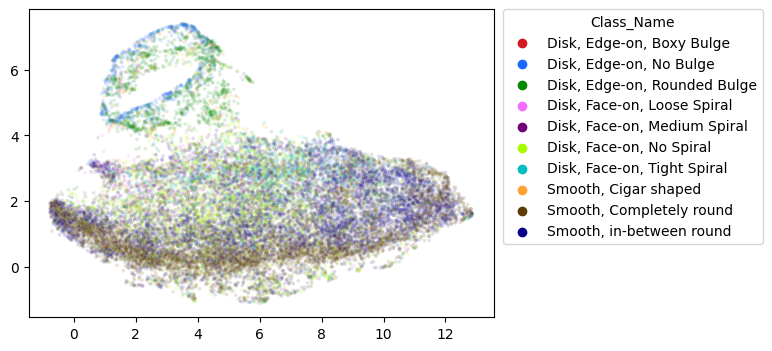

time: 16.3 s (started: 2023-06-11 16:01:49 -07:00)


In [14]:
import drnb.embed.pipeline as pl

pl.standard_eval(method="umap", dataset="galaxy10sdss")

In [12]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True, reduce=150).run(
    "galaxy10sdss-pca150",
    data=data,
    target=target,
    tags=["image"],
    url="https://astronn.readthedocs.io/en/latest/galaxy10sdss.html",
    verbose=True,
)

[16:00:11] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=783788;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=596037;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#569\569]8;;\

           INFO     Initial data shape: (21785, 14283)                                               ]8;id=219784;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=514092;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#75\75]8;;\

           INFO     Keeping all columns                                                            ]8;id=569959;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=848909;file:///home/james/dev/drnb/src/drnb/preprocess.py#72\72]8;;\

           INFO     Data shape after filtering columns: (21785, 14283)                              ]8;id=404607;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=312720;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=944456;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=664337;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#130\130]8;;\

           INFO     Data shape after filtering NAs: (21785, 14283)                                  ]8;id=325632;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=307110;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#141\141]8;;\

[16:00:16] INFO     Checked for duplicates: found 0                                                 ]8;id=192821;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=459734;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#153\153]8;;\

           INFO     No scaling                                                                     ]8;id=333426;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=330368;file:///home/james/dev/drnb/src/drnb/preprocess.py#27\27]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=582784;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=452026;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     Reducing initial dimensionality to 150                                          ]8;id=487326;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=552303;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#165\165]8;;\

[16:00:30] INFO     PCA: 150 components explain 91.32% of variance                                  ]8;id=88723;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=30276;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#168\168]8;;\

[16:00:32] INFO     Data shape after PCA: (21785, 150)                                              ]8;id=729358;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=295949;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#174\174]8;;\

           INFO     Writing data for galaxy10sdss-pca150                                            ]8;id=449114;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=484593;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#226\226]8;;\

[16:00:36] INFO     Processing target with initial shape (21785, 2)                                 ]8;id=337246;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=702134;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#197\197]8;;\

           INFO     Keeping all columns                                                            ]8;id=339068;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=26682;file:///home/james/dev/drnb/src/drnb/preprocess.py#72\72]8;;\

           INFO     Writing target for galaxy10sdss-pca150                                          ]8;id=287190;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=160974;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#226\226]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=621462;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=433420;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#241\241]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=524995;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=455539;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=537768;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=752611;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=840288;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=731666;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=178777;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=678616;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

           INFO     Using 'faiss' to find nearest neighbors                                          ]8;id=656704;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=340818;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#83\83]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=834277;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=995062;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#96\96]8;;\

[16:00:38] INFO     Writing numpy format to nn/galaxy10sdss-pca150.16.euclidean.exact.faiss.idx.npy ]8;id=672123;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=557627;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\

[16:00:40] INFO     Writing csv format to nn/galaxy10sdss-pca150.16.euclidean.exact.faiss.idx.csv   ]8;id=666761;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=675267;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

           INFO     Writing numpy format to                                                         ]8;id=984305;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=161031;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\
                    nn/galaxy10sdss-pca150.16.euclidean.exact.faiss.dist.npy                                       

[16:00:41] INFO     Writing csv format to nn/galaxy10sdss-pca150.16.euclidean.exact.faiss.dist.csv  ]8;id=217954;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=68357;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

[16:00:42] INFO     Writing numpy format to nn/galaxy10sdss-pca150.51.euclidean.exact.faiss.idx.npy ]8;id=254673;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=794957;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\

[16:00:48] INFO     Writing csv format to nn/galaxy10sdss-pca150.51.euclidean.exact.faiss.idx.csv   ]8;id=890021;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=921544;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

[16:00:49] INFO     Writing numpy format to                                                         ]8;id=270589;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=967732;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\
                    nn/galaxy10sdss-pca150.51.euclidean.exact.faiss.dist.npy                                       

[16:00:53] INFO     Writing csv format to nn/galaxy10sdss-pca150.51.euclidean.exact.faiss.dist.csv  ]8;id=129131;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=196981;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

[16:00:54] INFO     Writing numpy format to                                                         ]8;id=723989;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=214984;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\
                    nn/galaxy10sdss-pca150.151.euclidean.exact.faiss.idx.npy                                       

           INFO     Writing csv format to nn/galaxy10sdss-pca150.151.euclidean.exact.faiss.idx.csv  ]8;id=203829;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=423555;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

[16:00:57] INFO     Writing numpy format to                                                         ]8;id=202741;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=33056;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\
                    nn/galaxy10sdss-pca150.151.euclidean.exact.faiss.dist.npy                                      

           INFO     Writing csv format to nn/galaxy10sdss-pca150.151.euclidean.exact.faiss.dist.csv ]8;id=364755;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=561357;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

[16:01:01] INFO     Calculating triplets                                                            ]8;id=840044;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=610120;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#252\252]8;;\

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[16:01:02] INFO     Writing csv format to triplets/galaxy10sdss-pca150.5.1337.idx.csv               ]8;id=793576;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=362391;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

[16:01:03] INFO     Writing csv format to triplets/galaxy10sdss-pca150.5.1337.euclidean.csv         ]8;id=873146;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=216756;file:///home/james/dev/drnb/src/drnb/io/__init__.py#269\269]8;;\

           INFO     Writing numpy format to triplets/galaxy10sdss-pca150.5.1337.idx.npy             ]8;id=209848;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=988130;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\

           INFO     Writing numpy format to triplets/galaxy10sdss-pca150.5.1337.euclidean.npy       ]8;id=277440;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=377790;file:///home/james/dev/drnb/src/drnb/io/__init__.py#292\292]8;;\

           INFO     Writing pipeline result for galaxy10sdss-pca150                                 ]8;id=887940;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=39809;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#123\123]8;;\

time: 52.6 s (started: 2023-06-11 16:00:11 -07:00)


/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepr

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7897452375487722, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.70295503292136, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.10849361181240914, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.15356805141152172, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2082503251472726, info={'metric': 'euclidean', 'n_neighbors': 150})]

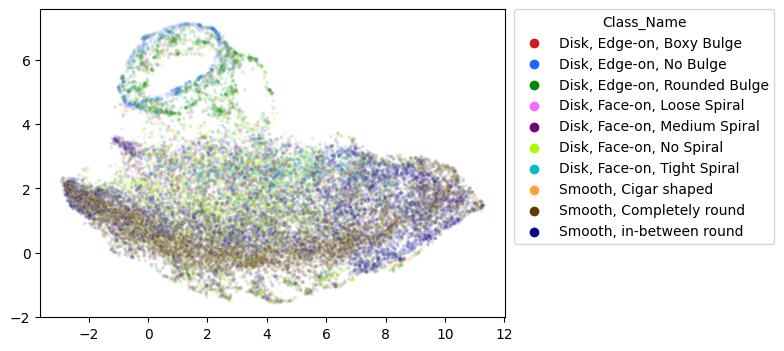

time: 17.8 s (started: 2023-06-11 16:01:04 -07:00)


In [13]:
import drnb.embed.pipeline as pl

pl.standard_eval(method="umap", dataset="galaxy10sdss-pca150")